In [2]:
# # adjsut the basic logging lovel of notebook
# import logging
# logging.basicConfig(level=logging.WARNING)

import os
import yaml
import numpy as np
import pandas as pd
import scipy as scp
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from matplotlib.lines import Line2D
from palettable.colorbrewer import qualitative
from auditory_cortex.dataloader import DataLoader
from auditory_cortex.models import Regression

from auditory_cortex.analyses import Correlations
from auditory_cortex import results_dir, aux_dir, saved_corr_dir, cache_dir
from auditory_cortex.utils import CorrelationUtils
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex import utils

from pycolormap_2d import ColorMap2DBremm, ColorMap2DZiegler
%matplotlib inline

2024-06-11 11:50:28.335921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:50:29.499328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-s

### range of optimal lmbdas and delays...

In [5]:
def plot_optimal_lmbdas_and_delays(model_name, identifier):
	corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

	fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
	
	i = 0
	ax[i].hist(corr_obj.data['opt_lmbdas'])
	ax[i].set_title(f"opt_lmbdas")
	ax[i].set_xlabel(f"lmbdas")
	# ax[i].set_xlim([-12, 7])
	
	i = 1
	opt_delays = corr_obj.data['opt_delays']
	ax[i].hist(opt_delays)
	ax[i].set_title(f"opt_delays (median) = {np.median(opt_delays):.3f}")
	ax[i].set_xlabel(f"delays")
	# ax[i].set_xlim([0, 100])

	plt.suptitle(model_name)



Using default normalizer file...


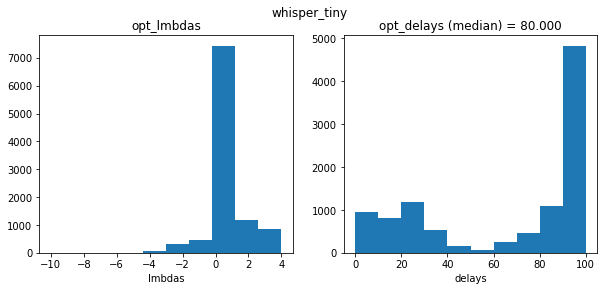

In [8]:
model_name = 'whisper_tiny'
identifier = 'test_all_trials_lmbdas'
# identifier = 'test_lmbdas_delays'
# identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


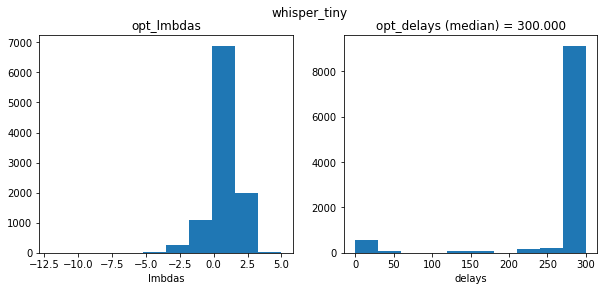

In [9]:
model_name = 'whisper_tiny'
# identifier = 'test_all_trials_lmbdas'
identifier = 'test_lmbdas_delays'
# identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


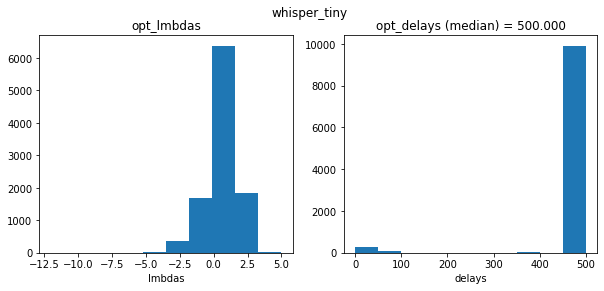

In [10]:
model_name = 'whisper_tiny'
# identifier = 'test_all_trials_lmbdas'
# identifier = 'test_lmbdas_delays'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


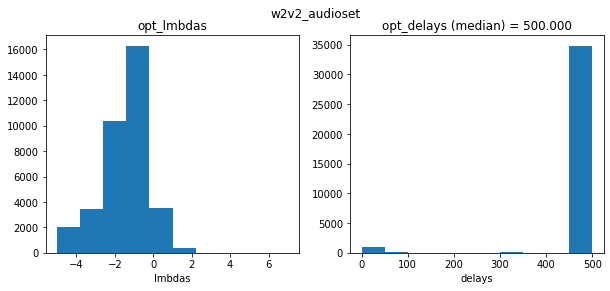

In [23]:
model_name = 'w2v2_audioset'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


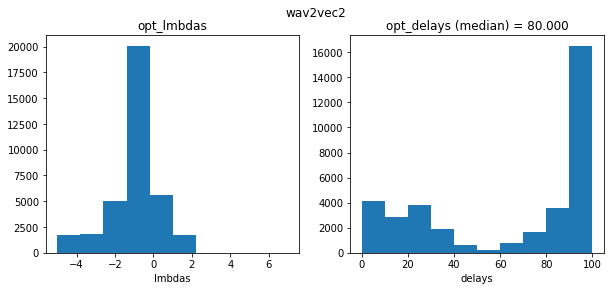

In [25]:
model_name = 'wav2vec2'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


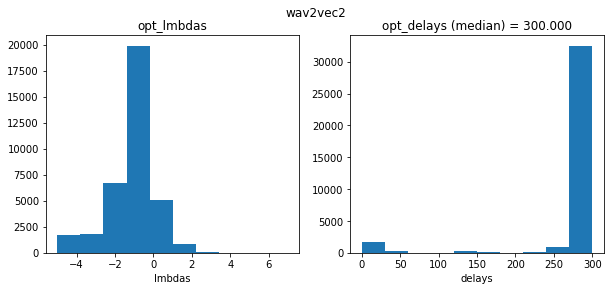

In [27]:
model_name = 'wav2vec2'
identifier = 'test_lmbdas_delays'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


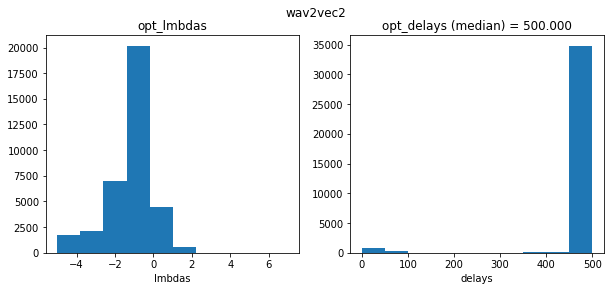

In [10]:
model_name = 'wav2vec2'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


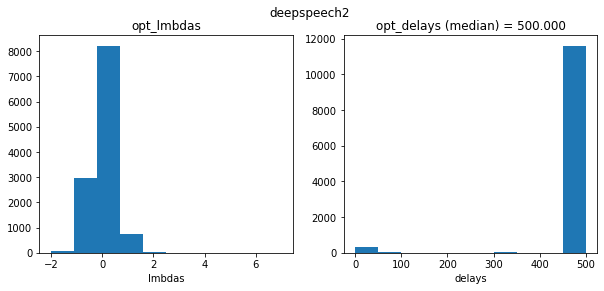

In [11]:
model_name = 'deepspeech2'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


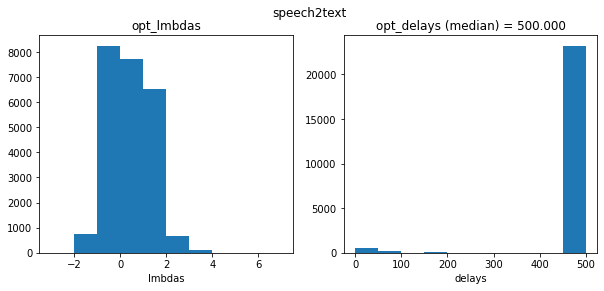

In [12]:
model_name = 'speech2text'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


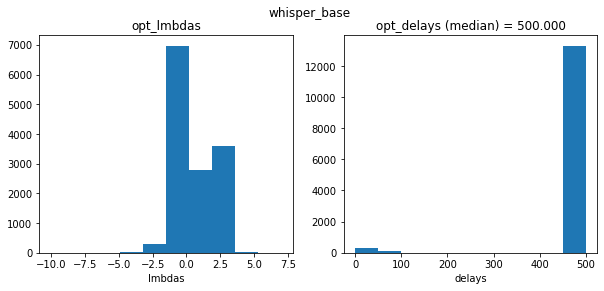

In [13]:
model_name = 'whisper_base'
identifier = 'delays_500'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


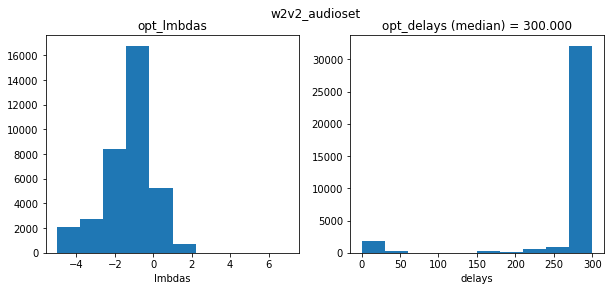

In [14]:
model_name = 'w2v2_audioset'
identifier = 'test_lmbdas_delays'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


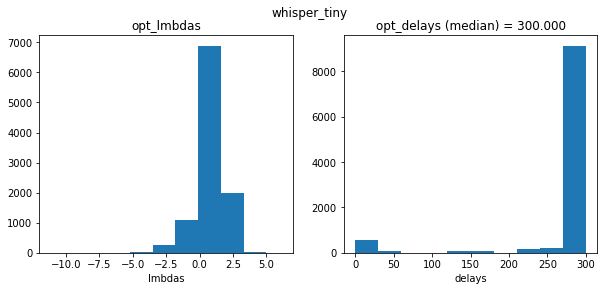

In [3]:
model_name = 'whisper_tiny'
identifier = 'test_lmbdas_delays'
plot_optimal_lmbdas_and_delays(model_name, identifier)

In [10]:
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


Using default normalizer file...


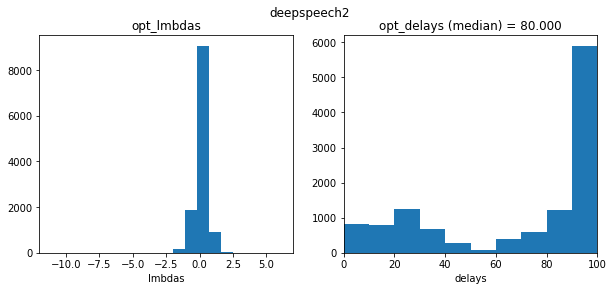

In [22]:
model_name = 'deepspeech2'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


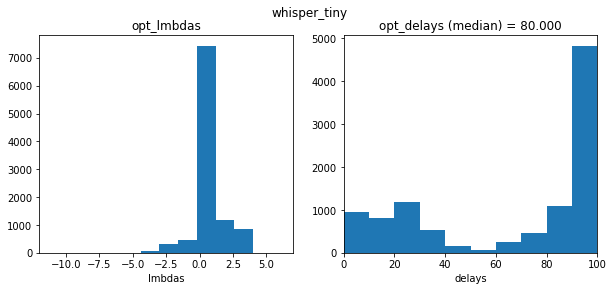

In [23]:
model_name = 'whisper_tiny'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


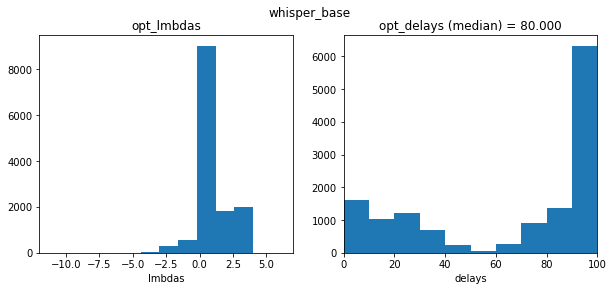

In [18]:
model_name = 'whisper_base'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


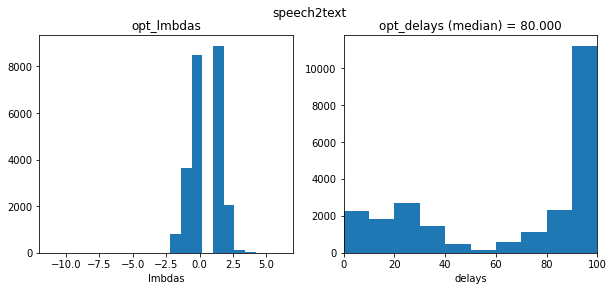

In [19]:
model_name = 'speech2text'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


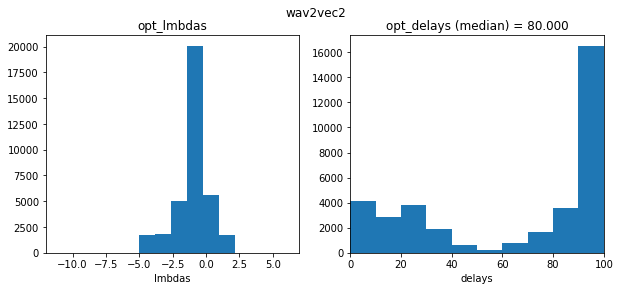

In [20]:
model_name = 'wav2vec2'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

Using default normalizer file...


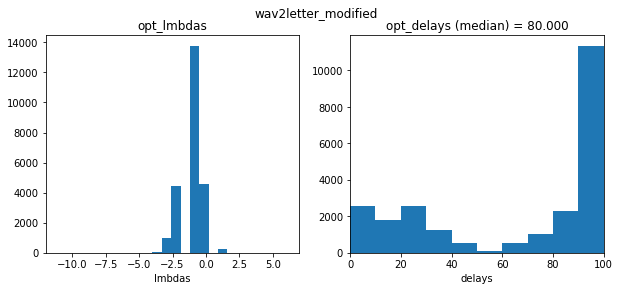

In [21]:
model_name = 'wav2letter_modified'
identifier = 'test_all_trials_lmbdas'
plot_optimal_lmbdas_and_delays(model_name, identifier)

#### whisper_base: delays (core vs belt)

##### identifier = test_lmbdas_delays

In [7]:
bin_width=50
delay=0
normalized=True

column='opt_delays'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [14]:
def get_lmbdas_primary_vs_non_primary(model_name, identifier):
	corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)
	area='core'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	area='non-primary'
	threshold= corr_obj.get_normalizer_threshold(
		bin_width=bin_width, poisson_normalizer=poisson_normalizer,
	)
	data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
			neural_area=area, bin_width=bin_width, delay=delay,
			threshold=threshold, normalized=normalized,
			column=column, use_stat_inclusion=use_stat_inclusion,
			inclusion_p_threshold=inclusion_p_threshold,
			use_poisson_null=use_poisson_null,

		)
	return data_dist_core, data_dist_belt


In [16]:
model_name = 'deepspeech2'
identifier = 'test_lmbdas_delays'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-1')

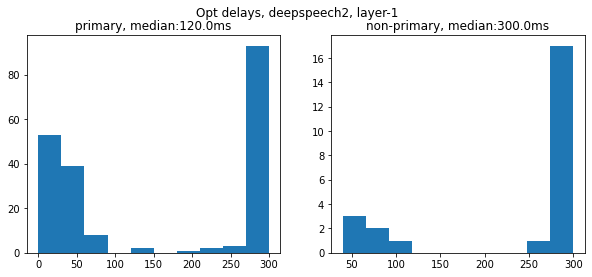

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [15]:

model_name = 'whisper_base'
identifier = 'test_lmbdas_delays'	#Done
	
data_dist_core, data_dist_belt = get_lmbdas_primary_vs_non_primary(
	model_name, identifier
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_base, layer-2')

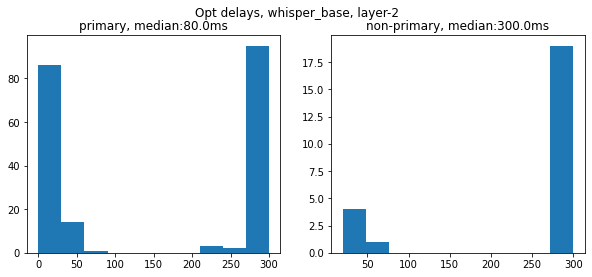

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [13]:
model_name = 'deepspeech2'
identifier = 'test_lmbdas_delays'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)

Using default normalizer file...


##### test_all_trials_lmbdas

In [53]:
model_name = 'whisper_base'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


Using default normalizer file...


In [54]:

bin_width=50
delay=0
normalized=True

column='opt_delays'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [62]:
area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_base, layer-0')

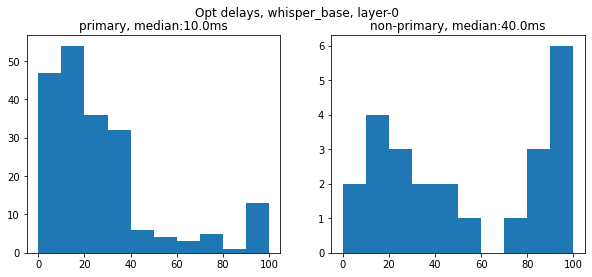

In [72]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 0
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-1')

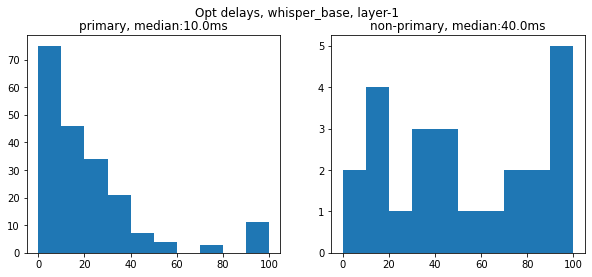

In [73]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-2')

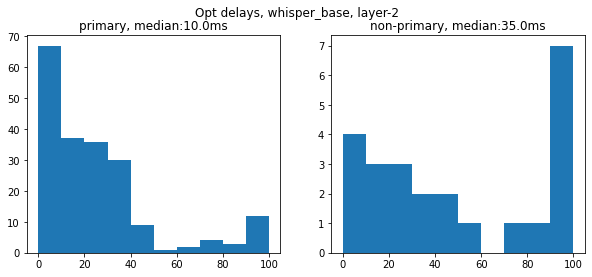

In [71]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-3')

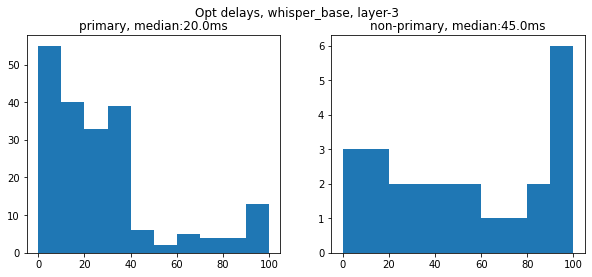

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-4')

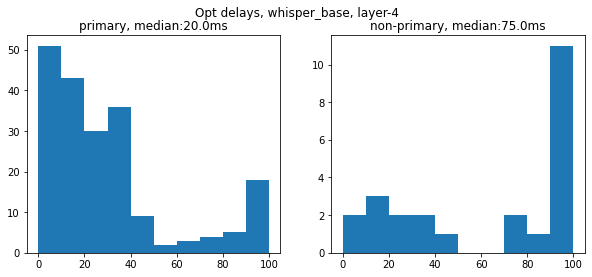

In [75]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_base, layer-5')

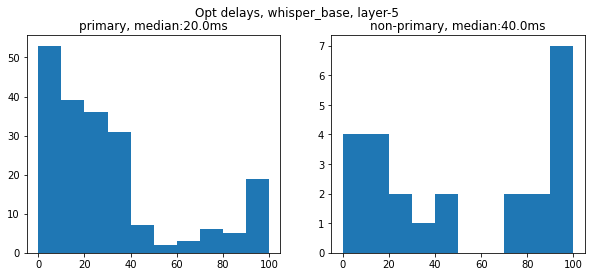

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

#### deepspeech2: delays (core vs belt)

In [78]:
model_name = 'deepspeech2'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-0')

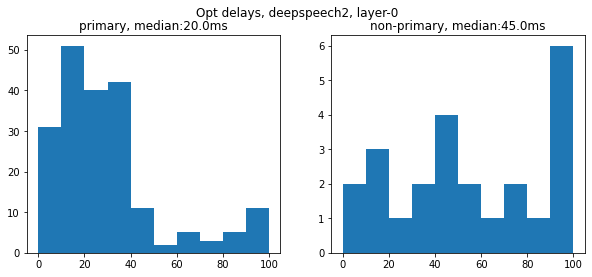

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 0
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-1')

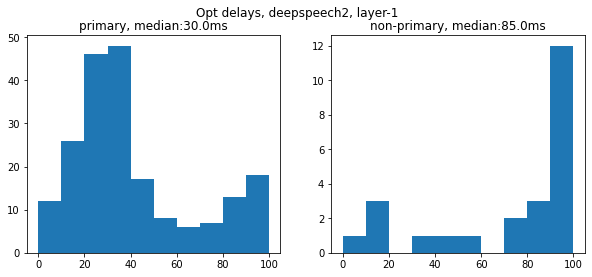

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-2')

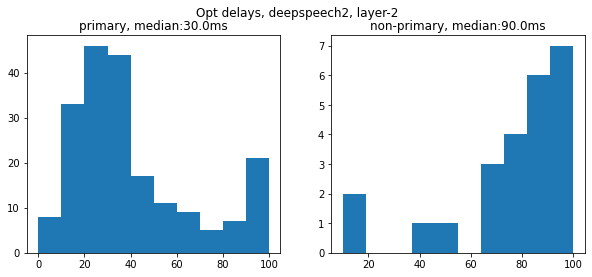

In [81]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-3')

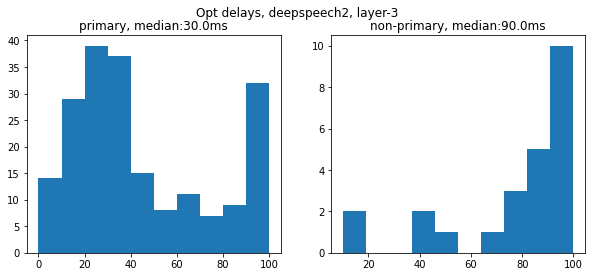

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-4')

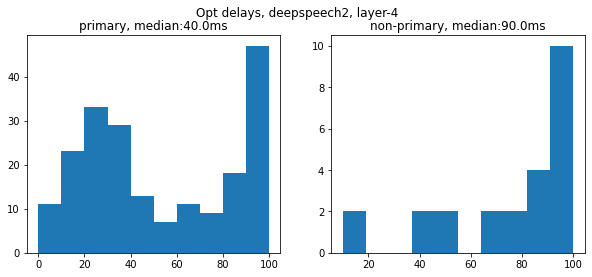

In [83]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, deepspeech2, layer-5')

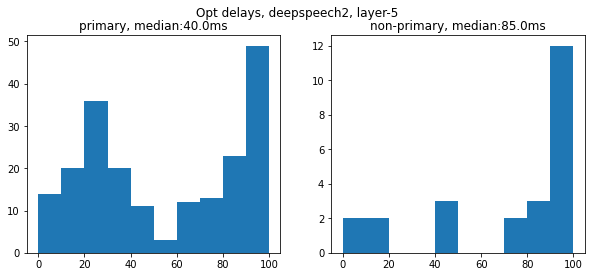

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

#### whisper_tiny

In [92]:
model_name = 'whisper_tiny'
identifier = 'test_all_trials_lmbdas'	#Done
	
corr_obj = Correlations(
	model_name=model_name+'_'+identifier,
	)


area='core'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)
area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_belt = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..
Reading exisiting normalizer thresholds...
Extracting column: opt_delays
Retreiving data using normalizer threshold..


Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-0')

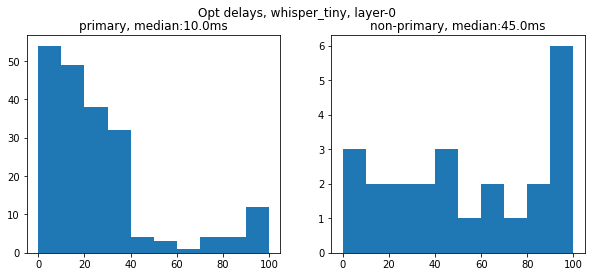

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 0
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-1')

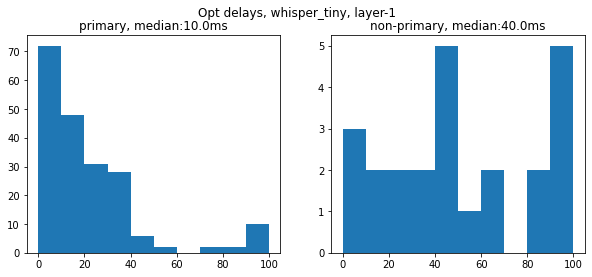

In [94]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 1
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-2')

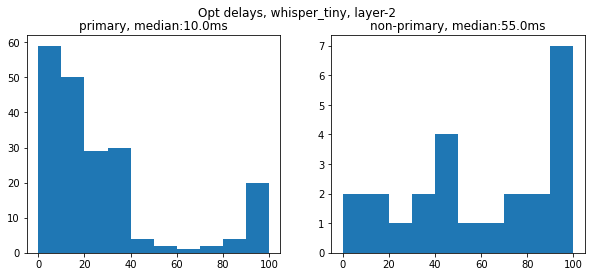

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 2
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-3')

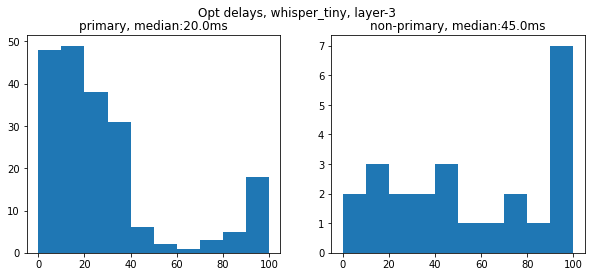

In [96]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 3
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-4')

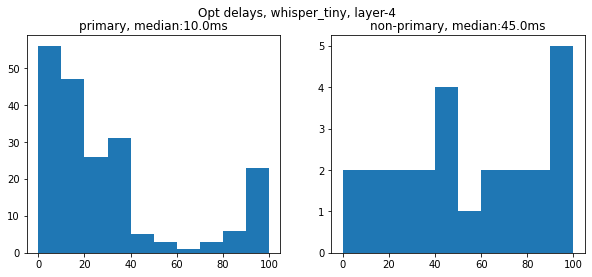

In [97]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 4
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

Text(0.5, 0.98, 'Opt delays, whisper_tiny, layer-5')

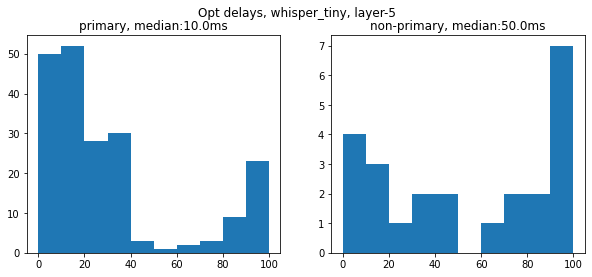

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
layer = 5
i=0
ax[i].hist(data_dist_core[layer])
ax[i].set_title(f"primary, median:{np.median(data_dist_core[layer])}ms")

i=1
ax[i].hist(data_dist_belt[layer])
ax[i].set_title(f"non-primary, median:{np.median(data_dist_belt[layer])}ms")
plt.suptitle(f"Opt delays, {model_name}, layer-{layer}")

In [40]:
session = 180730
corr_obj.data[(corr_obj.data['opt_delays']==100)&\
	(corr_obj.data['session']==session)
	].shape

(24, 16)

### core-belt comparison

In [2]:
area='all'
bin_width=50
delay=0
alpha=0.1
save_tikz=False
normalized=True
# identifier='_bins_corrected_100',
sig_offset_x=0
sig_offset_y=0.93
sig_ind_size=8
arch_ind_offset=1.0
arch_ind_lw=8
p_threshold=0.01
plot_baseline=False 
display_inter_quartile_range=True
display_dotted_lines=True
keep_xticks = True
keep_yticks = True
trained_identifier='trained_all_bins'
untrained_identifiers=None
baseline_identifier=None
plot_difference=False
tikz_indicator=None
column=None
indicate_significance=True
indicate_architecture=True
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

In [3]:
# model_name = 'deepspeech2'
# model_name = 'whisper_base'
model_name = 'w2v2_audioset'
# trained_identifier = 'trial_0'
# trained_identifier = 'test_all_trials'
# trained_identifier = 'test_all_trials_lmbdas'
trained_identifier = 'test_lmbdas_delays'
area='core'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

Using default normalizer file...


FileNotFoundError: [Errno 2] No such file or directory: '/depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/w2v2_audioset_test_all_trials_lmbdas_corr_results.csv'

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6665251349211877, occurs at x_coordinate: 7
Peak corr (max): 0.921801757827276, occurs at x_coordinate: 7
Number of samples: (24,)


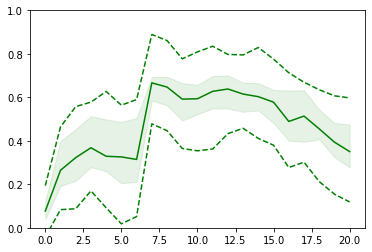

In [5]:
# model_name = 'deepspeech2'
# model_name = 'whisper_base'
model_name = 'w2v2_audioset'
# trained_identifier = 'trial_0'
# trained_identifier = 'test_all_trials'
trained_identifier = 'test_all_trials_lmbdas'
# trained_identifier = 'test_lmbdas_delays'
area='non-primary'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

### core-belt comparison...

#### 'test_all_trials_lmbdas'
compares 'test_all_trials_lmbdas' (lmbdas range 10e[-12,7]) to 'test_all_trials' (lmbdas range 10e[-7,-1])

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6847060731961874, occurs at x_coordinate: 2
Peak corr (max): 0.9105909916959696, occurs at x_coordinate: 2
Peak corr (median): 0.5916055352145219, occurs at x_coordinate: 2
Peak corr (max): 0.8783695191948977, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

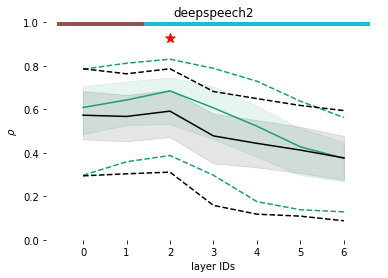

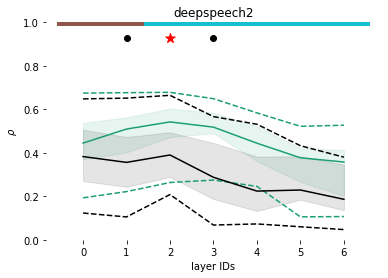

In [51]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6702589478154456, occurs at x_coordinate: 2
Peak corr (max): 0.9175154533547, occurs at x_coordinate: 2
Peak corr (median): 0.5916055352145219, occurs at x_coordinate: 2
Peak corr (max): 0.8783695191948977, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thresho

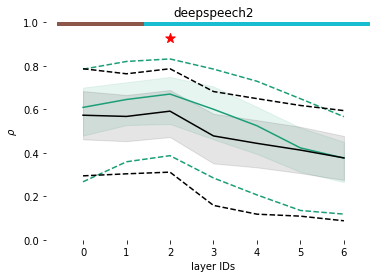

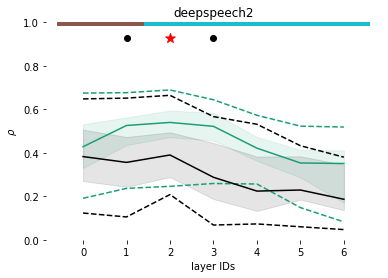

In [52]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6506755579756516, occurs at x_coordinate: 2
Peak corr (max): 0.917760671670002, occurs at x_coordinate: 1
Peak corr (median): 0.6071735705138674, occurs at x_coordinate: 1
Peak corr (max): 0.8724648383731899, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

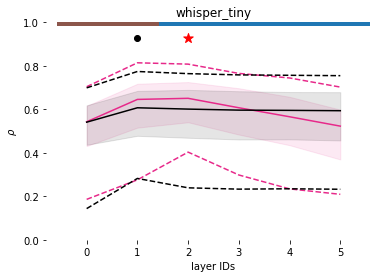

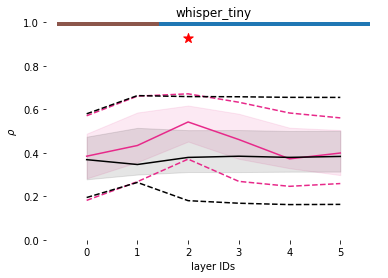

In [7]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6438426488320306, occurs at x_coordinate: 2
Peak corr (max): 0.9177475748388562, occurs at x_coordinate: 1
Peak corr (median): 0.6071735705138674, occurs at x_coordinate: 1
Peak corr (max): 0.8724648383731899, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

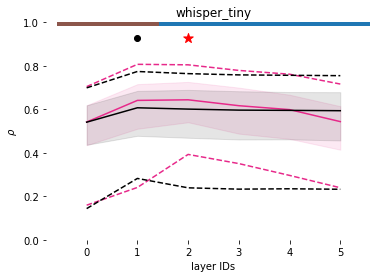

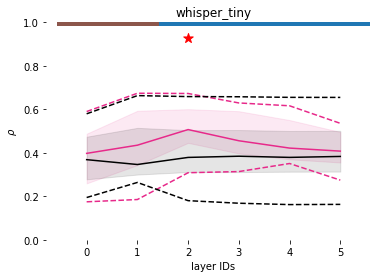

In [9]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
model_name='whisper_tiny'
# model_name='whisper_base'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6563660781835681, occurs at x_coordinate: 2
Peak corr (max): 0.9152546711808256, occurs at x_coordinate: 2
Peak corr (median): 0.6085150676463472, occurs at x_coordinate: 2
Peak corr (max): 0.8749557235158845, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

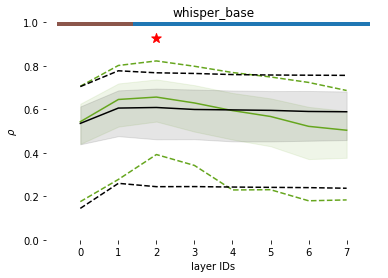

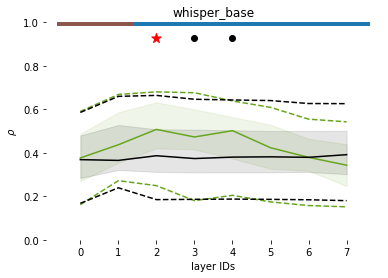

In [41]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
model_name='whisper_base'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.649717177303213, occurs at x_coordinate: 2
Peak corr (max): 0.9152545871038792, occurs at x_coordinate: 2
Peak corr (median): 0.6085150676463472, occurs at x_coordinate: 2
Peak corr (max): 0.8749557235158845, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

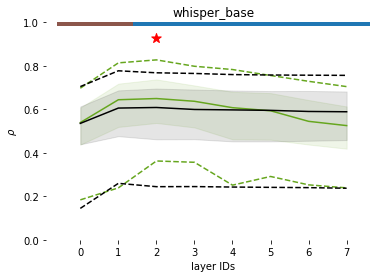

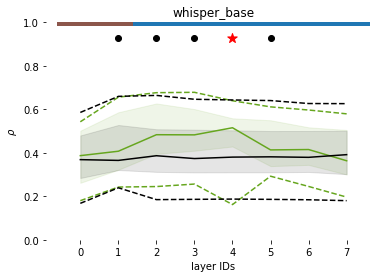

In [42]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
model_name='whisper_base'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6359928277938536, occurs at x_coordinate: 6
Peak corr (max): 0.8981545239413653, occurs at x_coordinate: 5
Peak corr (median): 0.5665019386952443, occurs at x_coordinate: 11
Peak corr (max): 0.8506403368495354, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

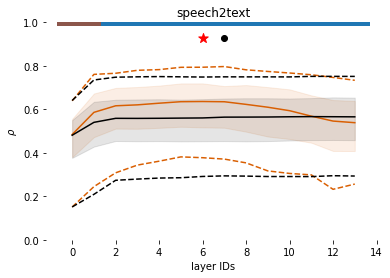

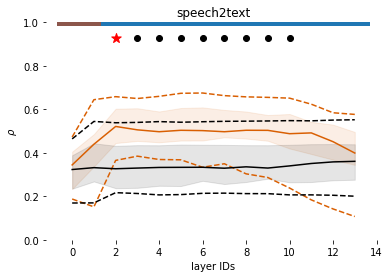

In [45]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
model_name='speech2text'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6362511960775113, occurs at x_coordinate: 5
Peak corr (max): 0.8735572536146705, occurs at x_coordinate: 3
Peak corr (median): 0.5665019386952443, occurs at x_coordinate: 11
Peak corr (max): 0.8506403368495354, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

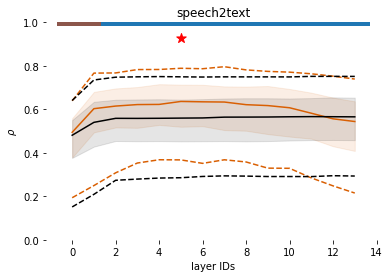

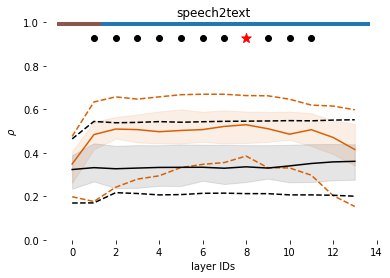

In [46]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
model_name='speech2text'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6398950323089788, occurs at x_coordinate: 8
Peak corr (max): 0.8683189205307057, occurs at x_coordinate: 9
Peak corr (median): 0.4202848666319537, occurs at x_coordinate: 17
Peak corr (max): 0.7571837486959143, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thr

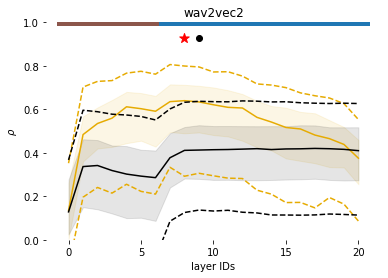

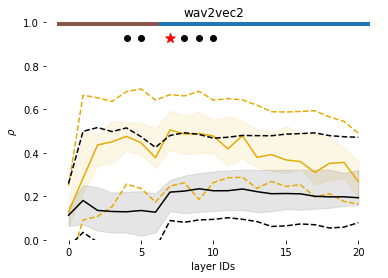

In [47]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
model_name='wav2vec2'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...


Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6395914784831926, occurs at x_coordinate: 7
Peak corr (max): 0.8617738824294442, occurs at x_coordinate: 9
Peak corr (median): 0.4202848666319537, occurs at x_coordinate: 17
Peak corr (max): 0.7571837486959143, occurs at x_coordinate: 1
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer

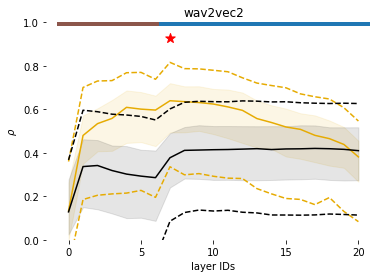

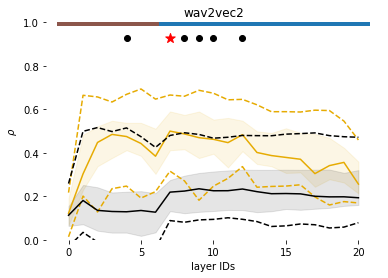

In [48]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
model_name='wav2vec2'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6106011761416787, occurs at x_coordinate: 4
Peak corr (max): 0.9048478700539148, occurs at x_coordinate: 5
Peak corr (median): 0.3896278703408042, occurs at x_coordinate: 0
Peak corr (max): 0.7894467077603404, occurs at x_coordinate: 0
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thre

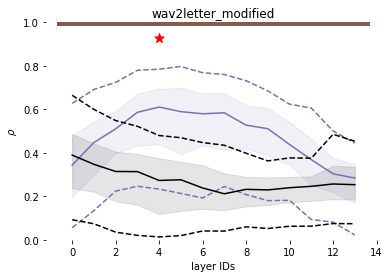

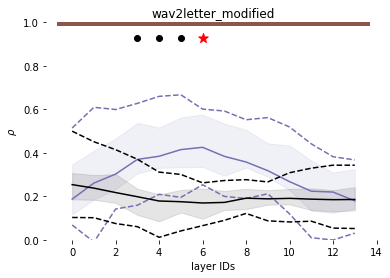

In [50]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
# model_name='wav2vec2'
model_name='wav2letter_modified'
trained_identifier='test_all_trials'
# trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6067559124632362, occurs at x_coordinate: 4
Peak corr (max): 0.902118506594174, occurs at x_coordinate: 5
Peak corr (median): 0.3896278703408042, occurs at x_coordinate: 0
Peak corr (max): 0.7894467077603404, occurs at x_coordinate: 0
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer thres

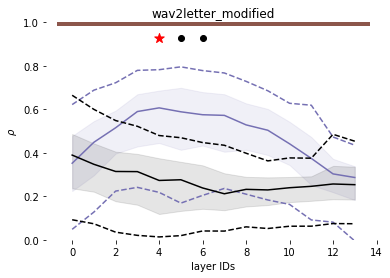

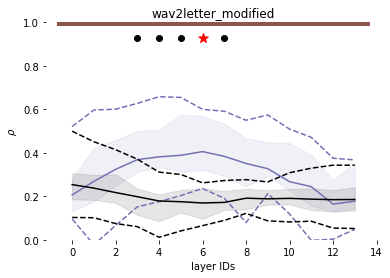

In [49]:

from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
normalized=True
save_tikz=False
# model_name='deepspeech2'
# model_name='whisper_tiny'
# model_name='whisper_base'
# model_name='speech2text'
# model_name='wav2vec2'
model_name='wav2letter_modified'
# trained_identifier='test_all_trials'
trained_identifier='test_all_trials_lmbdas'
untrained_identifiers = [
        'reset_weights_all_trials0', 'reset_weights_all_trials1',
		'reset_weights_all_trials2', 'reset_weights_all_trials3',
		# 'reset_weights_all_trials4'
                         ]
# trained_identifier = 'test_all_trials_lmbdas'

area_wise = peak_layer_core_non_primary_areas(
    
	model_name=model_name,
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
	normalized=normalized,
    bin_width=bin_width,
	use_stat_inclusion=False,
	save_tikz=save_tikz,

)

#### 'delay_500'
visualizing 'delay_500' and 'reset_delay_500'. both covering range of [0, 500] for delays..

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7244893876300617, occurs at x_coordinate: 2
Peak corr (max): 1.228014109994633, occurs at x_coordinate: 2
Peak corr (median): 0.6059953925571209, occurs at x_coordinate: 2
Peak corr (max): 1.1338453936746489, occurs at x_coordinate: 3
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7429645323022243, occurs at x_coordinate: 3
Peak corr (max): 1.1569967983393734, occurs at x_coordinate: 2
Peak corr (median): 0.6416659650530188, occurs at x_coordinate: 6
Peak corr (max): 1.0095500938909203, occurs at x_coordinate: 6
Number of neurons in dist for non-primary: 24


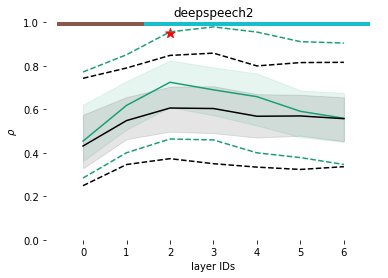

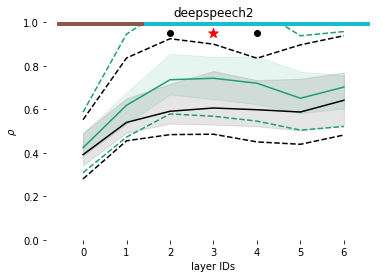

In [16]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='deepspeech2',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

2024-06-10 00:23:54.391370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 00:23:55.636285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-studio/cl

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7256873238806368, occurs at x_coordinate: 10
Peak corr (max): 1.2662830218998948, occurs at x_coordinate: 7
Peak corr (median): 0.5810905537305063, occurs at x_coordinate: 11
Peak corr (max): 1.0547744645665864, occurs at x_coordinate: 6
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.8151991887820371, occurs at x_coordinate: 11
Peak corr (max): 1.2132215715667327, occurs at x_coordinate: 13
Peak corr (median): 0.5803863614384065, occurs at x_coordinate: 13
Peak corr (max): 0.9528324830359124, occurs at x_coordinate: 5
Number of neurons in dist for non-primary

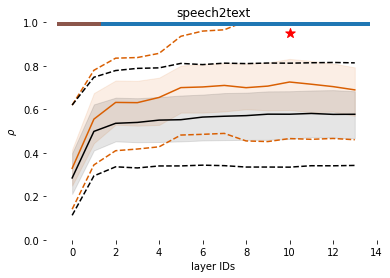

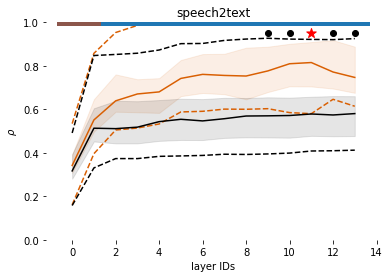

In [15]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='speech2text',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6927315119052081, occurs at x_coordinate: 4
Peak corr (max): 1.2709909192315685, occurs at x_coordinate: 4
Peak corr (median): 0.5470472287391978, occurs at x_coordinate: 2
Peak corr (max): 0.9075329761477032, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.754035728430541, occurs at x_coordinate: 5
Peak corr (max): 1.1534268580480558, occurs at x_coordinate: 5
Peak corr (median): 0.5230614917766186, occurs at x_coordinate: 2
Peak corr (max): 0.9499910191992014, occurs at x_coordinate: 2
Number of neurons in dist for non-primary: 24


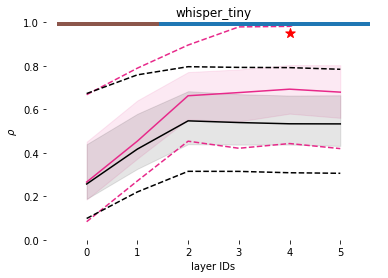

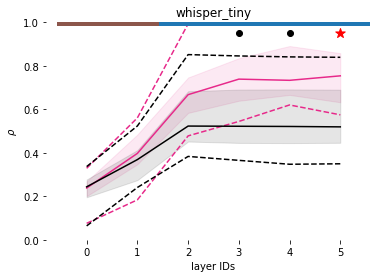

In [17]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='whisper_tiny',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7047409754108921, occurs at x_coordinate: 3
Peak corr (max): 1.280574462136335, occurs at x_coordinate: 6
Peak corr (median): 0.5392828173512548, occurs at x_coordinate: 2
Peak corr (max): 0.9052834687047924, occurs at x_coordinate: 2
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7587920064490108, occurs at x_coordinate: 7
Peak corr (max): 1.138852111690003, occurs at x_coordinate: 3
Peak corr (median): 0.5318076594118557, occurs at x_coordinate: 2
Peak corr (max): 0.9708167247789128, occurs at x_coordinate: 2
Number of neurons in dist for non-primary: 24


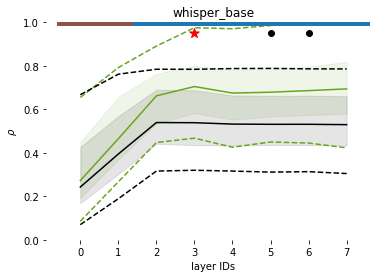

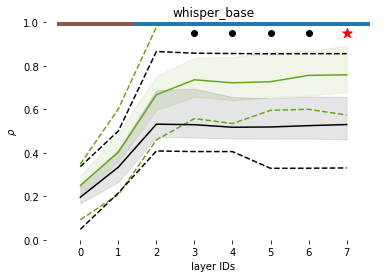

In [18]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='whisper_base',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.5523832490387329, occurs at x_coordinate: 9
Peak corr (max): 1.06947604574774, occurs at x_coordinate: 12
Peak corr (median): 0.6781444542665119, occurs at x_coordinate: 12
Peak corr (max): 1.376752487056371, occurs at x_coordinate: 12
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6257575867975589, occurs at x_coordinate: 10
Peak corr (max): 0.9595677647226872, occurs at x_coordinate: 12
Peak corr (median): 0.8219378657318026, occurs at x_coordinate: 12
Peak corr (max): 1.2911747284904294, occurs at x_coordinate: 12
Number of neurons in dist for non-primary:

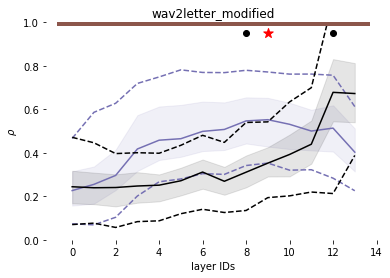

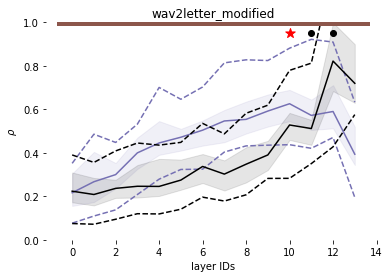

In [19]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='wav2letter_modified',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.726039852261714, occurs at x_coordinate: 7
Peak corr (max): 1.2934253026173108, occurs at x_coordinate: 8
Peak corr (median): 0.6118220109433073, occurs at x_coordinate: 10
Peak corr (max): 1.1884717734405772, occurs at x_coordinate: 9
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
Peak corr (median): 0.7741582566305528, occurs at x_coordinate: 9
Peak corr (max): 1.1534842610446203, occurs at x_coordinate: 7
Peak corr (median): 0.6866986176586359, occurs at x_coordinate: 16
Peak corr (max): 1.066877955669839, occurs at x_coordinate: 20
Number of neurons in dist for non-primary: 24

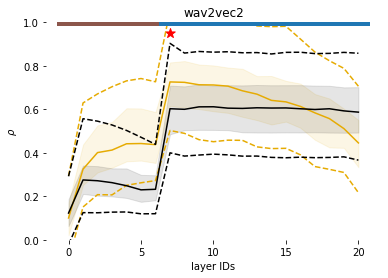

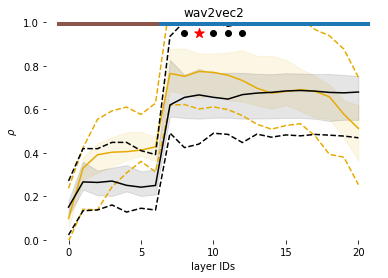

In [20]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='wav2vec2',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
model_name 'w2v2_audioset' not recognizable!!!
Peak corr (median): 0.7545091508919969, occurs at x_coordinate: 7
Peak corr (max): 1.3016959227061888, occurs at x_coordinate: 7
Peak corr (median): 0.603259646225699, occurs at x_coordinate: 7
Peak corr (max): 1.1946128821173194, occurs at x_coordinate: 7
Number of neurons in dist for core: 201
Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Using default normalizer file...
Retreiving data using normalizer threshold..
model_name 'w2v2_audioset' not recognizable!!!
Peak corr (median): 0.7566168185347935, occurs at x_coordinate: 14
Peak corr (max): 1.1558349301233255, occurs at x_coordinate: 7
Peak corr (median): 0.6814122612343207, occurs at x_coordinate: 10
Peak corr (max

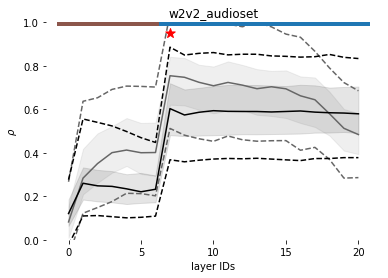

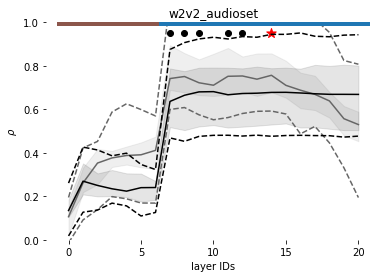

In [21]:
from auditory_cortex.plotters.tikzplots import peak_layer_core_non_primary_areas
bin_width = 50
trained_identifier = 'delays_500'
# trained_identifier='test_all_trials',
untrained_identifiers = [
        'reset_delays_500',
                         ]
area_wise = peak_layer_core_non_primary_areas(
    model_name='w2v2_audioset',
	trained_identifier=trained_identifier,
	untrained_identifiers=untrained_identifiers,
    bin_width=bin_width,
    offset_y=0.95,
    normalized=True,
	use_stat_inclusion=False,
	inclusion_p_threshold=0.01,
	save_tikz=False
)

### neural predictions at high delay

In [28]:
model_name = 'whisper_base'
identifier = 'delays_500'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


In [30]:
corr_obj.data[(corr_obj.data['session']==200206)& \
	(corr_obj.data['channel']==32)
			]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
10376,200206.0,0.0,32.0,50.0,0.0,0.0,0.548284,494.402655,0.551641,-0.547288,0.704778,500.0,20.0,-4.0,conv,0.653099
10440,200206.0,1.0,32.0,50.0,0.0,0.0,0.688147,5308.309639,5.941251,-5.936935,0.704778,500.0,0.0,-3.0,conv,0.819701
10504,200206.0,2.0,32.0,50.0,0.0,0.0,0.675709,5036.928578,5.620071,-5.615717,0.704778,500.0,20.0,-8.0,transformer,0.804885
10568,200206.0,3.0,32.0,50.0,0.0,0.0,0.683490,2132.880389,2.387196,-2.382881,0.704778,500.0,0.0,-2.0,transformer,0.814153
10632,200206.0,4.0,32.0,50.0,0.0,0.0,0.643187,1187.958298,1.325492,-1.321138,0.704778,500.0,20.0,-1.0,transformer,0.766145
10696,200206.0,5.0,32.0,50.0,0.0,0.0,0.623937,586.155872,0.654017,-0.649663,0.704778,500.0,20.0,-1.0,transformer,0.743215
10760,200206.0,6.0,32.0,50.0,0.0,0.0,0.593646,464.032433,0.517755,-0.513401,0.704778,500.0,20.0,0.0,transformer,0.707133
10824,200206.0,7.0,32.0,50.0,0.0,0.0,0.575651,280.727887,0.313229,-0.308875,0.704778,500.0,20.0,1.0,transformer,0.685699


In [49]:
model_name = 'whisper_base'

dataloader = DataLoader()
reg_obj = Regression(model_name)

Using default normalizer file...
Creating regression obj for: 'whisper_base'
Using default normalizer file...


In [54]:
from auditory_cortex.plotters.tikzplots import plot_spike_counts

def trials_and_predictions(
	reg_obj,
	dataloader,
	model_name,
	session, 
	delay,
	bin_width,
	sent_ids,
	layer,
	ch,
	):
	force_reload=False
	predicted_spike_rate = {}
	predicted_spike_rate[model_name] = reg_obj.neural_prediction(
		session, bin_width=bin_width, delay=delay, sents=sent_ids, layer_IDs=[layer],
		force_reload=force_reload
		)

	trial_color = 'gray'
	mean_color = 'k'
	prediction_colors = None
	ind_trial_width=1
	mean_line_width=2
	alpha = 0.8


	all_trials = dataloader.get_neural_data_for_repeated_trials(
			session, bin_width=bin_width, delay=delay,
			sent_IDs=sent_ids
		)

	ax = plot_spike_counts(
		bin_width,
		ch, all_trials, predicted_spike_rate,
		trial_color, mean_color, prediction_colors,
		ind_trial_width, mean_line_width, alpha=alpha
	)
	corr = utils.compute_avg_test_corr(
		all_trials[...,ch],
		predicted_spike_rate[model_name][:,ch].squeeze())

	ax.set_title(f"{model_name}, bw-{bin_width}, delay-{delay}, Corr={corr[0]:.3f}")

#### core session - 200206

Reading raw features from /scratch/gilbreth/ahmedb/cache/whisper_base/whisper_base_raw_features.pkl
Resamping ANN features at bin-width: 50
DataLoader: Extracting spikes for session-200206...Loading Neural data for session: 200206 ... Done.
Reading neural spikes from dataset object. 
# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 200206
For fold=0: 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 3.99 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.74 sec/mapping.
It takes (on avg.) 0.11 minutes/iteration...!
Loading Neural data for session: 200206 ... Done.


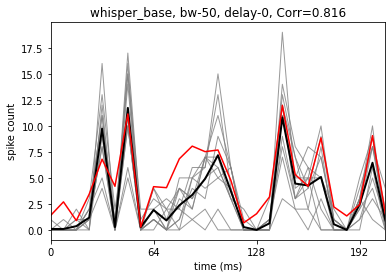

In [50]:
session = 200206
bin_width = 50
delay=0
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 200206
For fold=0: 
DataLoader: Extracting spikes for session-200206...Reading neural spikes from dataset object. 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 12.46 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.60 sec/mapping.
It takes (on avg.) 0.25 minutes/iteration...!


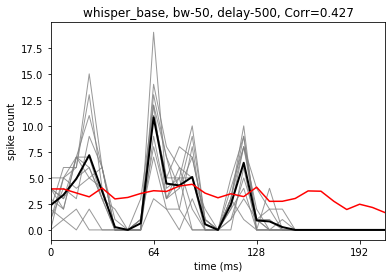

In [51]:
session = 200206
bin_width = 50
delay=500
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

#### non-primary session..

In [3]:
model_name = 'whisper_base'
identifier = 'delays_500'
corr_obj = Correlations(
		model_name=model_name+'_'+identifier,
		)

Using default normalizer file...


In [4]:
bin_width=50
delay=0
normalized=True

column='session'
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

area='non-primary'
threshold= corr_obj.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_core = corr_obj.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

	)

Reading exisiting normalizer thresholds...
Extracting column: session
Retreiving data using normalizer threshold..


In [5]:
np.unique(data_dist_core[2])

array([180613., 180728., 180730., 191121., 191210., 200205., 200219.])

In [12]:
corr_obj.data[(corr_obj.data['session']==200205) &\
	(corr_obj.data['normalizer']>threshold) &\
	(corr_obj.data['layer']==2)
	]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
9986,200205.0,2.0,2.0,50.0,0.0,0.0,0.314214,2.038156,0.011953,-0.004244,0.104780,500.0,500.0,0.0,transformer,0.970704
9987,200205.0,2.0,3.0,50.0,0.0,0.0,0.249079,1.929047,0.010308,-0.003332,0.173801,500.0,500.0,0.0,transformer,0.597463
9993,200205.0,2.0,9.0,50.0,0.0,0.0,0.312498,1.850336,0.012189,-0.004270,0.094071,500.0,500.0,0.0,transformer,1.018872
9994,200205.0,2.0,10.0,50.0,0.0,0.0,0.251494,2.018651,0.009073,-0.002539,0.144301,500.0,500.0,-1.0,transformer,0.662053
9996,200205.0,2.0,12.0,50.0,0.0,0.0,0.318646,1.983615,0.009668,-0.002608,0.105701,500.0,500.0,-1.0,transformer,0.980093
10005,200205.0,2.0,21.0,50.0,0.0,0.0,0.219815,2.149682,0.011659,-0.004055,0.094499,500.0,500.0,-1.0,transformer,0.715062
10027,200205.0,2.0,43.0,50.0,0.0,0.0,0.225538,1.776266,0.010633,-0.003059,0.131598,500.0,500.0,0.0,transformer,0.621718
10030,200205.0,2.0,46.0,50.0,0.0,0.0,0.140120,1.587349,0.014136,-0.005079,0.098669,500.0,500.0,0.0,transformer,0.446076
10042,200205.0,2.0,58.0,50.0,0.0,0.0,0.268493,1.964065,0.009053,-0.002362,0.165953,500.0,500.0,0.0,transformer,0.659083


In [46]:
corr_obj.data[(corr_obj.data['session']==180728) &\
	(corr_obj.data['normalizer']>threshold) &\
	(corr_obj.data['layer']==2)
	]

,session,layer,channel,bin_width,delay,train_cc_raw,test_cc_raw,poiss_entropy,uncertainty_per_spike,bits_per_spike_NLB,normalizer,N_sents,opt_delays,opt_lmbdas,layer_type,normalized_test_cc
1444,180728.0,2.0,4.0,50.0,0.0,0.0,0.253486,1.698457,0.017016,-0.007775,0.141999,500.0,500.0,0.0,transformer,0.672685
1445,180728.0,2.0,5.0,50.0,0.0,0.0,0.231382,1.673321,0.014994,-0.006023,0.100337,500.0,500.0,0.0,transformer,0.730465


# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 180728
For fold=0: 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 3.99 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 0.62 sec/mapping.
It takes (on avg.) 0.08 minutes/iteration...!


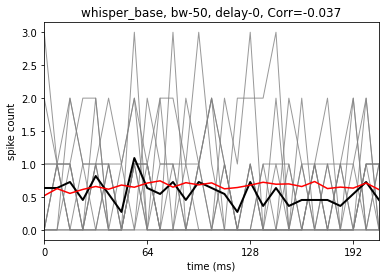

In [55]:
session = 180728
bin_width = 50
delay=0
sent_ids = [12]
layer = 2
ch = 4

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

# of iterations requested: 1, 
                 # of lambda samples per iteration: 20
Itr: 1:
5_fold CV for session: 180728
For fold=0: 
DataLoader: Extracting spikes for session-180728...Reading neural spikes from dataset object. 
For fold=1: 
For fold=2: 
For fold=3: 
For fold=4: 
It takes (on avg.) 4.58 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 0.62 sec/mapping.
It takes (on avg.) 0.09 minutes/iteration...!


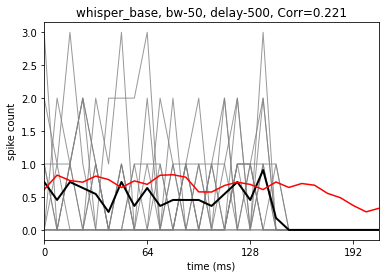

In [56]:
session = 180728
bin_width = 50
delay=500
sent_ids = [12]
layer = 2

trials_and_predictions(
	reg_obj, dataloader, model_name, session, delay, 
	bin_width, sent_ids, layer, ch,
)

### TRF results

In [2]:
area='all'
bin_width=50
delay=0
alpha=0.1
save_tikz=False
normalized=True
# identifier='_bins_corrected_100',
sig_offset_x=0
sig_offset_y=0.93
sig_ind_size=8
arch_ind_offset=1.0
arch_ind_lw=8
p_threshold=0.01
plot_baseline=False 
display_inter_quartile_range=True
display_dotted_lines=True
keep_xticks = True
keep_yticks = True
trained_identifier='trained_all_bins'
untrained_identifiers=None
baseline_identifier=None
plot_difference=False
tikz_indicator=None
column=None
indicate_significance=True
indicate_architecture=True
poisson_normalizer=True
use_stat_inclusion=False
inclusion_p_threshold = 0.01
use_poisson_null=True

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.6538969766331664, occurs at x_coordinate: 1
Peak corr (max): 0.9143117942055502, occurs at x_coordinate: 1
Number of samples: (201,)


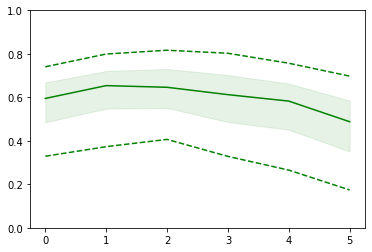

In [3]:
# model_name = 'deepspeech2'
model_name = 'whisper_tiny'
# model_name = 'w2v2_audioset'

trained_identifier = 'trf_300'
area='core'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")

Using default normalizer file...
Reading exisiting normalizer thresholds...
Retreiving data using normalizer threshold..
Peak corr (median): 0.5481855897377955, occurs at x_coordinate: 2
Peak corr (max): 0.6959754435144245, occurs at x_coordinate: 2
Number of samples: (24,)


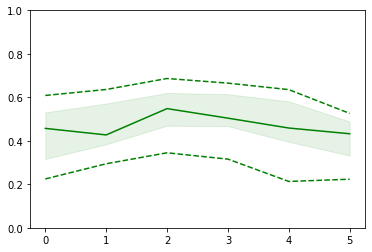

In [4]:
# model_name = 'deepspeech2'
model_name = 'whisper_tiny'
# model_name = 'w2v2_audioset'

trained_identifier = 'trf_300'
area='non-primary'
corr_obj_trained = Correlations(model_name+'_'+trained_identifier)
threshold= corr_obj_trained.get_normalizer_threshold(
	bin_width=bin_width, poisson_normalizer=poisson_normalizer,
)
data_dist_trained = corr_obj_trained.get_corr_all_layers_for_bin_width(
		neural_area=area, bin_width=bin_width, delay=delay,
		threshold=threshold, normalized=normalized,
		column=column, use_stat_inclusion=use_stat_inclusion,
		inclusion_p_threshold=inclusion_p_threshold,
		use_poisson_null=use_poisson_null,

			)
# plotting individual distributions...
color = 'green'
ax=RegPlotter.plot_line_with_shaded_region(
	data_dict=data_dist_trained, color=color, alpha=alpha,
	display_inter_quartile_range=display_inter_quartile_range,
	display_dotted_lines=display_dotted_lines,
	)
plt.ylim([0,1])
print(f"Number of samples: {data_dist_trained[0].shape}")